In [103]:
## NAME:Devyani Mardia
## NETID: dm1633
## Group members: David & Devyani

################
## Code for HW 3 problem 3
##
## INSTRUCTIONS:
## The following file implements adaBoost with decision stump as the weak
## learner.
##
## It uses adaBoost to predict whether a movie has an above average rating or
## not according to various features. 
## 
## Fill in the code in parts labeled "FILL IN". In part (a), you will complete
## the implementation of a decision stump classifier. In part (b), you will
## complete the implementation of adaBoost. 
##
################


################
## Part (b)
##
## adaBoost
## INPUT: X (n--by--p) matrix, Y (n--by--1) vector of {-1, +1}, M integer
## OUTPUT: a list of 4 elements
##          "feat_to_split" (M--by--1) vector describing which feature to 
##                          split for the decision stump created at iteration m
##          "thresh_to_split" (M--by--1) vector describing where to split
##                          the feature
##          "alphas" (M--by--1) the alpha coefficient as described in the 
##                           adaboost algorithm
##          "errs" (M--by--1) the WEIGHTED predictive error of the m-th decision
##                            stump
##
##


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def adaBoost(X, Y, M):
    n = X.shape[0]
    
    ## Initial weights
    wts = np.full(n, 1/n)
    ## FILL IN

    feat_to_split = np.zeros(M)
    thresh_to_split = np.zeros(M)
    errs = np.zeros(M)
    alphas = np.zeros(M)

    for m in range(M):
        stump = decisionStumpClassifier(X, Y, wts)
        feat_to_split[m] = stump[0]
        thresh_to_split[m] = stump[1]
        Ypred = np.where(X[:, int(feat_to_split[m])] > thresh_to_split[m], 1, -1)
        errs[m] = np.sum(wts * (Ypred != Y))/ np.sum(wts)
        
        alphas[m] = np.log((1 - errs[m]) / errs[m])
        ## FILL IN
                
        wts = wts * np.exp(alphas[m] * (Y != Ypred)) ## FILL IN

    return [feat_to_split, thresh_to_split, alphas, errs]

In [104]:
################
## Part (a)
## 
## decisionStumpClassifier
## INPUT:  X  (n--by--p) matrix, Y length n vector of {-1, +1}, 
##         wts length n vector of non-negative numbers.
## OUTPUT: a length three vector "result"
##         result[1]: the feature on which to split
##         result[2]: the value on which to split
##         result[3]: the weighted predictive error
##
##  NOTE: for adaBoost, we do not need to specify 
##        whether we should predict -1 on left and +1 on right or vice versa.
##        We only need to specify which feature and which value to split.
## 


def decisionStumpClassifier(X, Y, wts):
    n, p = X.shape
    thresh = np.zeros(p)
    best_errs = np.zeros(p)

    for j in range(p):
        sorted_ixs = np.argsort(X[:, j])
        feat = X[sorted_ixs, j]
        breaks = np.where(feat[1:] - feat[:-1] > 0)[0]

        Yord = Y[sorted_ixs]
        wts_o = wts[sorted_ixs]
        Yrev = np.flip(Yord)
        rwts_o = np.flip(wts_o)

        ## minus_left: a length (n-1) vector such that
        ##      minus_left[i] = sum_{j=1}^i wts_j * Indicator(Y_j == -1)
        ## This is the error accrued by predicting data point
        ## from 1, 2, ... i as -1
        minus_left = np.cumsum(wts_o * (1 + Yord) / 2)[:-1]
        
        ## plus_right: a length (n-1) vector such that
        ##      plus_right[i] = sum_{j=i+1}^n wts_j * Indicator(Y_j == +1)
        ## This is the error accrued by predicting data point
        ## from i+1, i+2, ..., n as +1
        plus_right = np.flip( np.cumsum(rwts_o * (1 - Yrev) / 2)[:-1] )
        
        ## plus_left: a length (n-1) vector such that
        ##      plus_left[i] = sum_{j=1}^i wts_j * Indicator(Y_j == +1)
        ## This is the error accrued by predicting data point
        ## from 1, 2, ... i as +1
        plus_left = np.cumsum(wts_o * (1 - Yord) / 2)[:-1]
        ## FILL IN
        
        ## minus_right: a length (n-1) vector such that
        ##      minus_right[i] = sum_{j=1}^i wts_j * Indicator(Y_j == -1)
        ## This is the error accrued by predicting data point
        ## from i+1, i+2, ..., n as -1
        minus_right = np.flip( np.cumsum(rwts_o * (1 + Yrev) / 2)[:-1] )
        ## FILL IN

        errs = np.minimum(minus_left + plus_right, plus_left + minus_right)

        ix = np.where(errs == np.min(errs[breaks]))[0]

        thresh[j] = X[sorted_ixs[ix[0]], j]
        best_errs[j] = np.min(errs[breaks])

    best_j = np.argmin(best_errs)
    result = [best_j, thresh[best_j], np.min(best_errs)]
    return result


# Test decision stump:
X1 = np.array([1,1,1,1,2,2,2,3,4,4,4,4,4])
X2 = np.random.rand(13)
X = np.column_stack((X1, X2))
Y = np.array([1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1])
decisionStumpClassifier(X, Y, np.full((13,), 1/13))

[0, 2.0, 0.07692307692307693]

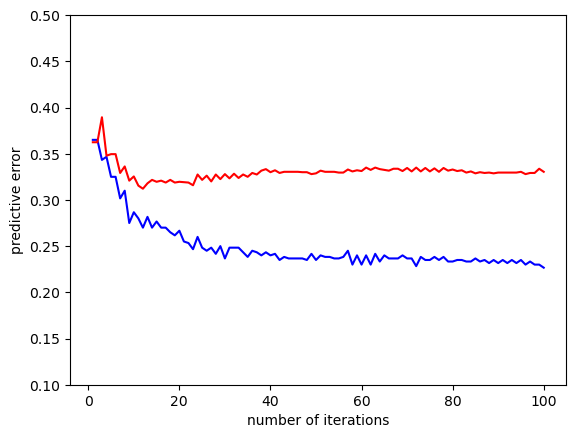

Baseline Error: 0.500  AdaBoost Error: 0.330


In [105]:
##############
# AdaBoost on movies data set


movies = pd.read_csv("movies_hw3.csv")
movies.dropna(inplace=True)

Y = np.where(movies["vote_average"] > np.mean(movies["vote_average"]), 1, -1)
feats = ["runtime", "log_budget", "age", "Action", "Adventure", "Romance", "Comedy", "Drama", "Horror", "Thriller"]
X = movies[feats].values

ntrain = 600
train_ix = np.random.choice(movies.shape[0], ntrain)
test_ix = [x for x in range(movies.shape[0]) if x not in train_ix]

Xtrain = X[train_ix, :]
Ytrain = Y[train_ix]

Xtest = X[test_ix, :]
Ytest = Y[test_ix]

p = X.shape[1]

M = 100
ada_res = adaBoost(Xtrain, Ytrain, M)
feat_to_split = ada_res[0]
thresh_to_split = ada_res[1]
alphas = ada_res[2]


Hval_train = np.zeros(Ytrain.shape[0])
Hval_test = np.zeros(Ytest.shape[0])

train_errs = np.zeros(M)
test_errs = np.zeros(M)

for m in range(M):
    Hval_train += alphas[m]*np.where(Xtrain[:, int(feat_to_split[m])] > thresh_to_split[m], 1, -1)
    Hval_test += alphas[m]*np.where(Xtest[:, int(feat_to_split[m])] > thresh_to_split[m], 1, -1)

    Ytrain_pred = np.sign(Hval_train)
    Ytest_pred = np.sign(Hval_test)

    train_errs[m] = np.mean(np.abs(Ytrain - Ytrain_pred))/2
    test_errs[m] = np.mean(np.abs(Ytest - Ytest_pred))/2

baseline_error = np.mean(np.abs(Ytest - np.mean(Ytrain))) / 2

plt.plot(np.arange(1, M+1), train_errs, 'blue')
plt.plot(np.arange(1, M+1), test_errs, 'red')
plt.ylim([0.1, 0.5])
plt.xlabel("number of iterations")
plt.ylabel("predictive error")
plt.show()

print("Baseline Error: {:.3f}  AdaBoost Error: {:.3f}".format(baseline_error, test_errs[-1]))

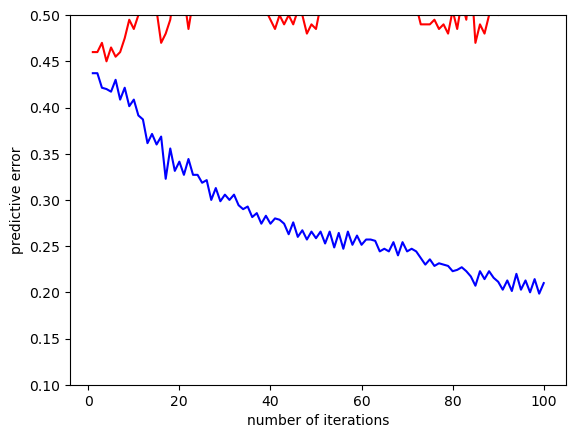

Baseline Error: 0.480  AdaBoost Error: 0.510


In [106]:
#########
## AdaBoost on stocks dataset
##
##

stocks = pd.read_csv("sp500_long.csv")
stocks = stocks[["BAC", "JPM", "GOOGL", "C", "GS"]].values

ndays = stocks.shape[0]
lag = 7

num_comp = stocks.shape[1]

Y = stocks[lag:ndays, 1] ## JPM is the second column in "stocks" and therefore index 1

## X is a matrix of dimension   (ndays-lag) x (num_comp*lag+1)
X = np.ones((ndays-lag, num_comp*lag))
for ell in range(lag):
    X[:, (num_comp*ell):(num_comp*(ell+1))] = stocks[ell:(ndays-lag+ell), :]

ntrain = 700
ntest = 200

train_ixs = np.arange(ntrain)
test_ixs = np.arange(ntrain, ntrain+ntest)

Ytrain = np.where(Y[train_ixs] > 0, 1, -1)
Xtrain = X[train_ixs, :]

Ytest = np.where(Y[test_ixs] > 0, 1, -1)
Xtest = X[test_ixs, :]

p = X.shape[1]

M = 100

ada_res = adaBoost(Xtrain, Ytrain, M)

feat_to_split = ada_res[0]
thresh_to_split = ada_res[1]
alphas = ada_res[2]

Hval_train = np.zeros(Ytrain.shape[0])
Hval_test = np.zeros(Ytest.shape[0])

train_errs = np.zeros(M)
test_errs = np.zeros(M)

for m in range(M):
    Hval_train += alphas[m]*np.where(Xtrain[:, int(feat_to_split[m])] > thresh_to_split[m], 1, -1)
    Hval_test += alphas[m]*np.where(Xtest[:, int(feat_to_split[m])] > thresh_to_split[m], 1, -1)

    Ytrain_pred = np.sign(Hval_train)
    Ytest_pred = np.sign(Hval_test)

    train_errs[m] = np.mean(np.abs(Ytrain - Ytrain_pred))/2
    test_errs[m] = np.mean(np.abs(Ytest - Ytest_pred))/2


plt.plot(np.arange(1, M+1), train_errs, 'blue')
plt.plot(np.arange(1, M+1), test_errs, 'red')
plt.ylim([0.1, 0.5])
plt.xlabel("number of iterations")
plt.ylabel("predictive error")
plt.show()

baseline_error = np.mean(np.abs(1 - Ytest))/2 if np.mean(Ytrain) > 0 else np.mean(np.abs(1 + Ytest))/2

print(f"Baseline Error: {baseline_error:.3f}  AdaBoost Error: {test_errs[-1]:.3f}")

3C

In the first use case of AdaBoost, we predict whether a movie will be rated above average using some in-formation about its genre, runtime, budget, etc. Based on the plot produced by the code, we see that as the number of AdaBoost iterations M increases, we are able to reduce the training and testing errors (to a point, where our progress plateaus). The final AdaBoost error is 0.333. However, when we use the same AdaBoost to predict stock prices, we see that although our training error is reduced with each iter-ation, our testing error very quickly increases, sug-gesting that the AdaBoost is very quickly, and very extremely, overfitting the data. In the case of the stock data, AdaBoost is much more sensitive to the number of iterations than it is with the movie data. This is likely because stock data is much more com-plex than movie ratings (the actual phenomena that our model is trying to capture are likely much more straightforward, and the available covariates likely capture much of the actual variance of the movie rating) and because of the structure of the data (the movie data is modeling binary response data, while the stock price data is much more granular).

The first graph is not very sensitive to the number of iterations but extremely sensitive to M in the second graph


For the first model, Predicting movie ratings: AdaBoost Error: 0.333
For the second model, Predicting company's stock: AdaBoost Error: 0.510